### Loading the cleaned data

In [1]:
import pandas as pd
import datetime as dt 

df = pd.read_csv("../data/processed/data_cleaned.csv", parse_dates=['InvoiceDate'])

### Define RFM snapshot data

In [2]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Snapshot date: {snapshot_date}")

Snapshot date: 2011-12-10 12:50:00


### RFM Feature Creation

In [3]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date-x.max()).days,
    'InvoiceNo' : 'nunique',
    'TotlalPrice': 'sum'  
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


### RFM Scoring

In [4]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,114
1,12347.0,2,7,4310.00,4,4,4,444
2,12348.0,75,4,1797.24,2,3,4,234
3,12349.0,19,1,1757.55,3,1,4,314
4,12350.0,310,1,334.40,1,1,2,112


### Segment Customers (Manually)

In [5]:
def segment_customer(df):
    if df['RFM_Score'] == '444':
        return 'Champions'
    elif df['R_score'] >= 3 and df['F_score'] >= 3:
        return 'Loyal'
    elif df['R_score'] >= 3 and df['M_score'] >= 3:
        return 'Big Spenders'
    elif df['R_score'] == 4:
        return 'New Customers'
    elif df['F_score'] >= 3:
        return 'Frequent Buyers'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm['Segment'].value_counts()


Segment
At Risk            1853
Loyal              1034
Frequent Buyers     646
Champions           489
New Customers       179
Big Spenders        137
Name: count, dtype: int64

### Visualize Segments

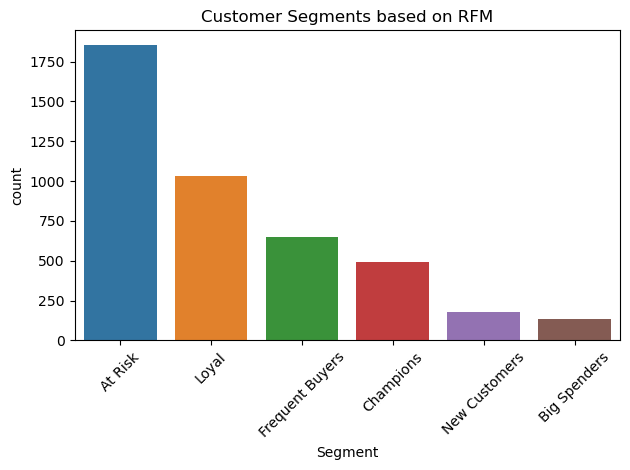

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Customer Segments based on RFM')
plt.tight_layout()
plt.show()


### K-Means Clustering on RFM

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


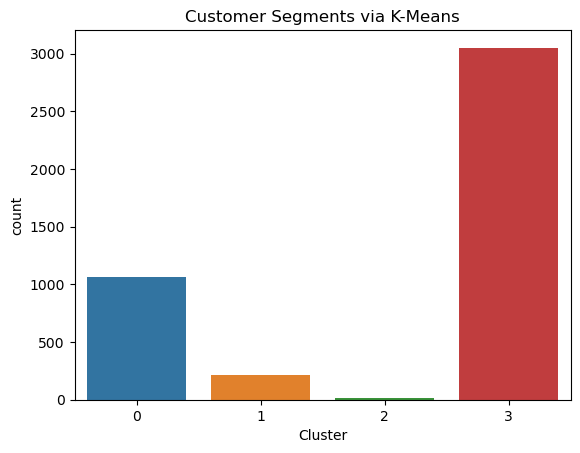

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  

rfm_clustering = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

sns.countplot(x='Cluster',data=rfm)
plt.title("Customer Segments via K-Means")
plt.show()

### RFM Heatmap

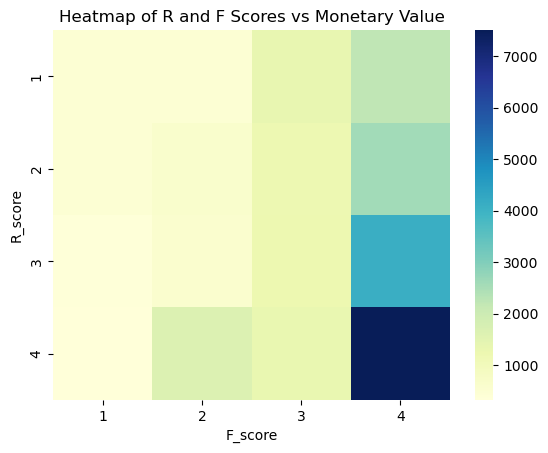

In [8]:
rfm_pivot = rfm.pivot_table(index='R_score', columns='F_score', values='Monetary', aggfunc='mean')
sns.heatmap(rfm_pivot, cmap='YlGnBu')
plt.title('Heatmap of R and F Scores vs Monetary Value')
plt.show()


###  Save RFM Table

In [9]:
rfm.to_csv("../data/processed/rfm_table.csv", index=False)